In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import random
import gc


In [3]:
revenue_3m_df = pd.read_csv('/content/drive/MyDrive/airline_data/3m_flight_revenue.csv')
booking_3m_df = pd.read_csv('/content/drive/MyDrive/airline_data/3m_flight_booking.csv')

# Print column names to see what we're working with
print("Revenue dataset columns for 3 months:")
print(revenue_3m_df.columns.tolist())
print("\nBooking dataset columns 3 months:")
print(booking_3m_df.columns.tolist())

# 12-month datasets
revenue_12m_df = pd.read_csv('/content/drive/MyDrive/airline_data/12m_flight_revenue.csv')
booking_12m_df = pd.read_csv('/content/drive/MyDrive/airline_data/12m_flight_booking.csv')

# Print column names to see what we're working with
print("Revenue dataset columns for 12 months:")
print(revenue_12m_df.columns.tolist())
print("\nBooking dataset columns for 12 months:")
print(booking_12m_df.columns.tolist())


Revenue dataset columns for 3 months:
[' Origin', ' Destination', 'Cabin', 'Booking Class', 'Booking Class Fare USD', 'Airline', 'Flight number', 'Dep_Date', 'Dep_time']

Booking dataset columns 3 months:
[' Origin', ' Destination', 'Cabin', 'Booking Class', ' Booking Class Fare USD ', 'Airline', 'Flight number', 'Dep_Date', 'Dep_time']
Revenue dataset columns for 12 months:
[' Origin', ' Destination', 'Cabin', 'Booking Class', 'Booking Class Fare USD', 'Airline', 'Flight number', 'Dep_Date', 'Dep_time']

Booking dataset columns for 12 months:
[' Origin', ' Destination', 'Cabin', 'Booking Class', ' Booking Class Fare USD ', 'Airline', 'Flight number', 'Dep_Date', 'Dep_time']


In [4]:
# Function to clean column names
def clean_column_names(df):
    df.columns = df.columns.str.strip()
    return df

# Clean column names for all datasets
revenue_3m_df = clean_column_names(revenue_3m_df)
booking_3m_df = clean_column_names(booking_3m_df)
revenue_12m_df = clean_column_names(revenue_12m_df)
booking_12m_df = clean_column_names(booking_12m_df)

In [5]:
def fill_fare_values(revenue_df, booking_df):
    # Create a lookup dictionary from booking dataset
    booking_df = clean_column_names(booking_df)

    # Create a composite key for matching
    def create_key(df):
        return (df['Origin'].astype(str) + '_' +
                df['Destination'].astype(str) + '_' +
                df['Cabin'].astype(str) + '_' +
                df['Booking Class'].astype(str) + '_' +
                df['Airline'].astype(str) + '_' +
                df['Flight number'].astype(str) + '_' +
                df['Dep_Date'].astype(str) + '_' +
                df['Dep_time'].astype(str))

    # Create keys for both datasets
    booking_df['match_key'] = create_key(booking_df)
    revenue_df['match_key'] = create_key(revenue_df)

    # Create fare lookup dictionary
    fare_lookup = booking_df.set_index('match_key')['Booking Class Fare USD'].to_dict()

    # Fill NaN values using the lookup dictionary
    revenue_df['Booking Class Fare USD'] = revenue_df['match_key'].map(fare_lookup)

    # Drop the temporary match_key column
    revenue_df = revenue_df.drop('match_key', axis=1)

    return revenue_df


In [6]:
# 4. Function to add the new forecasting features
def add_forecast_features(df):
    # Initialize new columns with 0
    df['overbooking'] = 0
    df['no_show'] = 0
    df['denied_boarding'] = 0
    df['cancellation'] = 0

    return df

In [7]:
# Process 3-month datasets
print("Processing 3-month datasets...")
revenue_3m_df = fill_fare_values(revenue_3m_df, booking_3m_df)
revenue_3m_df = add_forecast_features(revenue_3m_df)
booking_3m_df = add_forecast_features(booking_3m_df)

# Process 12-month datasets
print("Processing 12-month datasets...")
revenue_12m_df = fill_fare_values(revenue_12m_df, booking_12m_df)
revenue_12m_df = add_forecast_features(revenue_12m_df)
booking_12m_df = add_forecast_features(booking_12m_df)

# Save all processed datasets
revenue_3m_df.to_csv('processed_revenue_3m.csv', index=False)
booking_3m_df.to_csv('processed_booking_3m.csv', index=False)
revenue_12m_df.to_csv('processed_revenue_12m.csv', index=False)
booking_12m_df.to_csv('processed_booking_12m.csv', index=False)


Processing 3-month datasets...
Processing 12-month datasets...


In [8]:
# First define the create_key function outside other functions
def create_key(df):
    return (df['Origin'].astype(str) + '_' +
            df['Destination'].astype(str) + '_' +
            df['Cabin'].astype(str) + '_' +
            df['Booking Class'].astype(str) + '_' +
            df['Airline'].astype(str) + '_' +
            df['Flight number'].astype(str) + '_' +
            df['Dep_Date'].astype(str) + '_' +
            df['Dep_time'].astype(str))

# Verify the results
def verify_dataset(df, name):
    print(f"\nVerifying {name}:")
    print(f"Total rows: {len(df)}")
    print(f"NaN values in Booking Class Fare USD: {df['Booking Class Fare USD'].isna().sum()}")
    print(f"Sample of fares (first 5 non-null values):")
    print(df[df['Booking Class Fare USD'].notna()]['Booking Class Fare USD'].head())
    print("\nSample of first 5 rows:")
    print(df.head())

# Verify all datasets
verify_dataset(revenue_3m_df, "3-month Revenue Dataset")
verify_dataset(booking_3m_df, "3-month Booking Dataset")
verify_dataset(revenue_12m_df, "12-month Revenue Dataset")
verify_dataset(booking_12m_df, "12-month Booking Dataset")

# Additional verification for matching keys
print("\nAnalyzing matching between datasets:")
print("\n3-month datasets analysis:")
revenue_3m_keys = create_key(revenue_3m_df)
booking_3m_keys = create_key(booking_3m_df)
print(f"Revenue unique keys: {len(revenue_3m_keys.unique())}")
print(f"Booking unique keys: {len(booking_3m_keys.unique())}")
print(f"Keys in revenue but not in booking: {len(set(revenue_3m_keys) - set(booking_3m_keys))}")
print(f"Keys in booking but not in revenue: {len(set(booking_3m_keys) - set(revenue_3m_keys))}")

print("\n12-month datasets analysis:")
revenue_12m_keys = create_key(revenue_12m_df)
booking_12m_keys = create_key(booking_12m_df)
print(f"Revenue unique keys: {len(revenue_12m_keys.unique())}")
print(f"Booking unique keys: {len(booking_12m_keys.unique())}")
print(f"Keys in revenue but not in booking: {len(set(revenue_12m_keys) - set(booking_12m_keys))}")
print(f"Keys in booking but not in revenue: {len(set(booking_12m_keys) - set(revenue_12m_keys))}")


Verifying 3-month Revenue Dataset:
Total rows: 16057
NaN values in Booking Class Fare USD: 1709
Sample of fares (first 5 non-null values):
0    136.38
1    209.10
2    327.29
3    154.56
4    245.47
Name: Booking Class Fare USD, dtype: float64

Sample of first 5 rows:
  Origin Destination Cabin Booking Class  Booking Class Fare USD Airline  \
0    BBB         DDD     Y             T                  136.38      AA   
1    BBB         DDD     Y             N                  209.10      AA   
2    BBB         DDD     Y             L                  327.29      AA   
3    BBB         DDD     Y             Q                  154.56      AA   
4    BBB         DDD     Y             E                  245.47      AA   

   Flight number    Dep_Date Dep_time  overbooking  no_show  denied_boarding  \
0            306  2023-10-02    06:05            0        0                0   
1            306  2023-10-02    06:05            0        0                0   
2            306  2023-10-02    0

In [14]:
from datetime import datetime, timedelta

In [15]:
def load_datasets():
    """Load all four datasets"""
    print("Loading datasets...")
    try:
        revenue_3m_df = pd.read_csv('processed_revenue_3m.csv')
        booking_3m_df = pd.read_csv('processed_booking_3m.csv')
        revenue_12m_df = pd.read_csv('processed_revenue_12m.csv')
        booking_12m_df = pd.read_csv('processed_booking_12m.csv')
        print("All datasets loaded successfully!")
        return revenue_3m_df, booking_3m_df, revenue_12m_df, booking_12m_df
    except Exception as e:
        print(f"Error loading datasets: {e}")
        return None, None, None, None

In [19]:
def prepare_forecasting_data(df):
    """
    Prepare airline dataset by adding realistic values for overbooking, no-show,
    denied boarding, and cancellation based on industry patterns and booking characteristics.
    """
    # Create copy to avoid modifying original
    df = df.copy()

    # Convert Dep_Date to datetime if not already
    df['Dep_Date'] = pd.to_datetime(df['Dep_Date'])

    # Extract hour from Dep_time string safely
    def extract_hour(time_str):
        try:
            # Handle different time formats
            if ':' in str(time_str):
                return int(str(time_str).split(':')[0])
            return int(str(time_str)[:2])  # Take first two characters as hour
        except:
            return 12  # Default to noon if conversion fails

    # 1. Calculate no-show probability
    df['day_of_week'] = df['Dep_Date'].dt.dayofweek
    df['hour'] = df['Dep_time'].apply(extract_hour)

    # Base no-show rates by booking class
    booking_class_noshow = {
        'F': 0.02, 'J': 0.03, 'Y': 0.05, 'B': 0.06,
        'H': 0.07, 'K': 0.08, 'L': 0.09, 'M': 0.10,
        'N': 0.11, 'Q': 0.12, 'S': 0.13, 'T': 0.14,
        'V': 0.15, 'W': 0.12, 'G': 0.13
    }

    # Calculate base no-show rate
    df['no_show'] = df['Booking Class'].map(lambda x: booking_class_noshow.get(x, 0.10))

    # Adjust for day of week
    weekend_mask = df['day_of_week'].isin([5, 6])
    df.loc[weekend_mask, 'no_show'] *= 1.2

    # Adjust for early morning flights
    early_flight_mask = df['hour'].between(5, 9)
    df.loc[early_flight_mask, 'no_show'] *= 0.8

    # Add random variation
    df['no_show'] *= np.random.uniform(0.8, 1.2, size=len(df))

    # 2. Calculate cancellation rates
    # Use a fixed reference date if max date is problematic
    reference_date = pd.Timestamp('2024-01-01')
    df['days_to_departure'] = (df['Dep_Date'] - reference_date).dt.days

    df['cancellation'] = df['Booking Class'].map(lambda x: booking_class_noshow.get(x, 0.08) * 0.8)

    # Adjust for advance purchase
    df['cancellation'] *= np.where(df['days_to_departure'] > 30, 1.2,
                                 np.where(df['days_to_departure'] > 14, 1.0, 0.7))

    # Add random variation
    df['cancellation'] *= np.random.uniform(0.8, 1.2, size=len(df))

    # 3. Calculate overbooking levels
    df['overbooking'] = (df['no_show'] + df['cancellation']) * 1.1

    # Add route-specific variation
    df['route'] = df['Origin'] + '_' + df['Destination']
    route_factors = df.groupby('route')['Booking Class Fare USD'].mean()
    route_factors = (route_factors - route_factors.mean()) / route_factors.std()
    df['overbooking'] *= df['route'].map(lambda x: np.exp(route_factors.get(x, 0) * 0.1))

    # 4. Calculate denied boarding
    df['denied_boarding'] = df['overbooking'] * 0.02

    # Ensure all values are between 0 and 1
    for col in ['no_show', 'cancellation', 'overbooking', 'denied_boarding']:
        df[col] = df[col].clip(0, 1)

    # Drop temporary columns
    df = df.drop(['day_of_week', 'hour', 'days_to_departure', 'route'], axis=1)

    return df


In [20]:
def verify_forecasting_data(df, dataset_name):
    """Verify the forecasting data has been properly generated"""
    print(f"\nVerifying {dataset_name}:")
    print("\nSummary statistics for forecasting columns:")
    forecast_cols = ['no_show', 'cancellation', 'overbooking', 'denied_boarding']
    print(df[forecast_cols].describe())
    print("\nSample of first 5 rows for forecasting columns:")
    print(df[forecast_cols].head())
    print("\nChecking for any null values:")
    print(df[forecast_cols].isnull().sum())


In [21]:
def main():
    # 1. Load all datasets
    print("Step 1: Loading datasets...")
    revenue_3m_df, booking_3m_df, revenue_12m_df, booking_12m_df = load_datasets()

    if revenue_3m_df is None:
        return

    # 2. Process all datasets
    print("\nStep 2: Processing datasets...")
    print("Adding forecasting values to all datasets...")

    processed_revenue_3m = prepare_forecasting_data(revenue_3m_df)
    processed_booking_3m = prepare_forecasting_data(booking_3m_df)
    processed_revenue_12m = prepare_forecasting_data(revenue_12m_df)
    processed_booking_12m = prepare_forecasting_data(booking_12m_df)

    # 3. Verify the processed data
    print("\nStep 3: Verifying processed data...")
    verify_forecasting_data(processed_revenue_3m, "3-month Revenue Dataset")
    verify_forecasting_data(processed_booking_3m, "3-month Booking Dataset")
    verify_forecasting_data(processed_revenue_12m, "12-month Revenue Dataset")
    verify_forecasting_data(processed_booking_12m, "12-month Booking Dataset")

    # 4. Save processed datasets
    print("\nStep 4: Saving processed datasets...")
    processed_revenue_3m.to_csv('forecasting_revenue_3m.csv', index=False)
    processed_booking_3m.to_csv('forecasting_booking_3m.csv', index=False)
    processed_revenue_12m.to_csv('forecasting_revenue_12m.csv', index=False)
    processed_booking_12m.to_csv('forecasting_booking_12m.csv', index=False)
    print("All processed datasets have been saved!")

    print("\nData preparation complete! The processed datasets are ready for model development.")
    return processed_revenue_3m, processed_booking_3m, processed_revenue_12m, processed_booking_12m

if __name__ == "__main__":
    main()

Step 1: Loading datasets...
Loading datasets...
All datasets loaded successfully!

Step 2: Processing datasets...
Adding forecasting values to all datasets...

Step 3: Verifying processed data...

Verifying 3-month Revenue Dataset:

Summary statistics for forecasting columns:
            no_show  cancellation   overbooking  denied_boarding
count  16057.000000  16057.000000  16057.000000     16057.000000
mean       0.105467      0.053888      0.167621         0.003352
std        0.030229      0.016853      0.048428         0.000969
min        0.019243      0.013444      0.034220         0.000684
25%        0.086016      0.042032      0.135801         0.002716
50%        0.103614      0.049882      0.160060         0.003201
75%        0.122510      0.065512      0.195638         0.003913
max        0.215913      0.100784      0.387032         0.007741

Sample of first 5 rows for forecasting columns:
    no_show  cancellation  overbooking  denied_boarding
0  0.113873      0.087318     0.2

All datasets were successfully processed with no errors:

* 3-month Revenue Dataset (16,057 rows)
* 3-month Booking Dataset (17,027 rows)
* 12-month Revenue Dataset (191,712 rows)
* 12-month Booking Dataset (195,774 rows)


The generated values for all four columns look realistic:

* No-show rates: Average around 9-10% (typical for airlines)
* Cancellation rates: Average around 5% (reasonable)
* Overbooking levels: Around 15-16% (aligned with industry practices)
* Denied boarding: Around 0.3% (realistic, as it's typically very low)

# **Model Development**

In [6]:
class AirlineForecaster:
    def __init__(self, target_type):
        """
        Initialize forecaster for specific prediction type
        target_type: 'no_show', 'cancellation', 'overbooking', or 'denied_boarding'
        """
        self.target_type = target_type
        self.model = None
        self.scaler = StandardScaler()
        self.feature_importance = None

    def extract_hour(self, time_str):
        """Safely extract hour from time string"""
        try:
            # Handle different time formats
            if ':' in str(time_str):
                return int(str(time_str).split(':')[0])
            return int(str(time_str)[:2])  # Take first two characters as hour
        except:
            return 12  # Default to noon if conversion fails

    def prepare_features(self, df):
        """Prepare features for model training"""
        print(f"\nPreparing features for {self.target_type} prediction...")

        # Create copy to avoid modifying original
        df = df.copy()

        # Convert date columns safely
        try:
            df['Dep_Date'] = pd.to_datetime(df['Dep_Date'])
            df['DayOfWeek'] = df['Dep_Date'].dt.dayofweek
            df['Month'] = df['Dep_Date'].dt.month

            # Extract hour safely
            df['Hour'] = df['Dep_time'].apply(self.extract_hour)

            # Create route feature
            df['Route'] = df['Origin'] + '_' + df['Destination']

            # Basic features
            feature_cols = ['DayOfWeek', 'Month', 'Hour', 'Booking Class Fare USD']

            # Add cabin class
            df['Cabin'] = df['Cabin'].fillna('Unknown')
            cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')

            # Add booking class
            df['Booking Class'] = df['Booking Class'].fillna('Unknown')
            booking_dummies = pd.get_dummies(df['Booking Class'], prefix='Class')

            # Combine features
            X = pd.concat([
                df[feature_cols],
                cabin_dummies,
                booking_dummies
            ], axis=1)

            y = df[self.target_type]

            print(f"Number of features: {X.shape[1]}")
            print("Feature preparation completed successfully!")

            return X, y

        except Exception as e:
            print(f"Error in feature preparation: {str(e)}")
            raise

    def train_model(self, X_train, y_train):
        """Train Random Forest model"""
        print(f"\nTraining {self.target_type} prediction model...")

        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,  # Limit depth to prevent overfitting
            min_samples_split=5,
            random_state=42,
            n_jobs=-1
        )

        self.model.fit(X_train, y_train)

        # Calculate feature importance
        self.feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("Model training completed!")

    def evaluate_model(self, X_test, y_test):
        """Evaluate model performance"""
        print(f"\nEvaluating {self.target_type} prediction model...")

        predictions = self.model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)

        print(f"Mean Absolute Error: {mae:.4f}")
        print(f"Root Mean Squared Error: {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")

        return predictions

    def plot_results(self, y_test, predictions):
        """Create visualizations for model results"""
        plt.figure(figsize=(15, 5))

        # Plot 1: Predicted vs Actual
        plt.subplot(1, 3, 1)
        plt.scatter(y_test, predictions, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted {self.target_type.replace("_", " ").title()}')

        # Plot 2: Feature Importance
        plt.subplot(1, 3, 2)
        importance_data = self.feature_importance.head(10)
        sns.barplot(x='importance', y='feature', data=importance_data)
        plt.title('Top 10 Important Features')
        plt.xlabel('Feature Importance')

        # Plot 3: Prediction Error Distribution
        plt.subplot(1, 3, 3)
        error = y_test - predictions
        sns.histplot(error, kde=True)
        plt.title('Prediction Error Distribution')
        plt.xlabel('Prediction Error')

        plt.tight_layout()
        plt.show()


In [7]:
def train_specific_model(data_path, target_type):
    """Train and evaluate a specific type of model"""
    print(f"\n{'='*50}")
    print(f"Starting {target_type} prediction model training")
    print(f"{'='*50}")

    # Load data
    print("\nLoading data...")
    df = pd.read_csv(data_path)
    print(f"Dataset shape: {df.shape}")

    # Initialize forecaster
    forecaster = AirlineForecaster(target_type)

    try:
        # Prepare features
        X, y = forecaster.prepare_features(df)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Train model
        forecaster.train_model(X_train, y_train)

        # Evaluate model
        predictions = forecaster.evaluate_model(X_test, y_test)

        # Plot results
        forecaster.plot_results(y_test, predictions)

        # Clear memory
        gc.collect()

        return forecaster

    except Exception as e:
        print(f"Error in model training pipeline: {str(e)}")
        return None


Starting no_show prediction model training

Loading data...
Dataset shape: (195774, 14)

Preparing features for no_show prediction...
Number of features: 32
Feature preparation completed successfully!

Training no_show prediction model...
Model training completed!

Evaluating no_show prediction model...
Mean Absolute Error: 0.0107
Root Mean Squared Error: 0.0133
R² Score: 0.8401


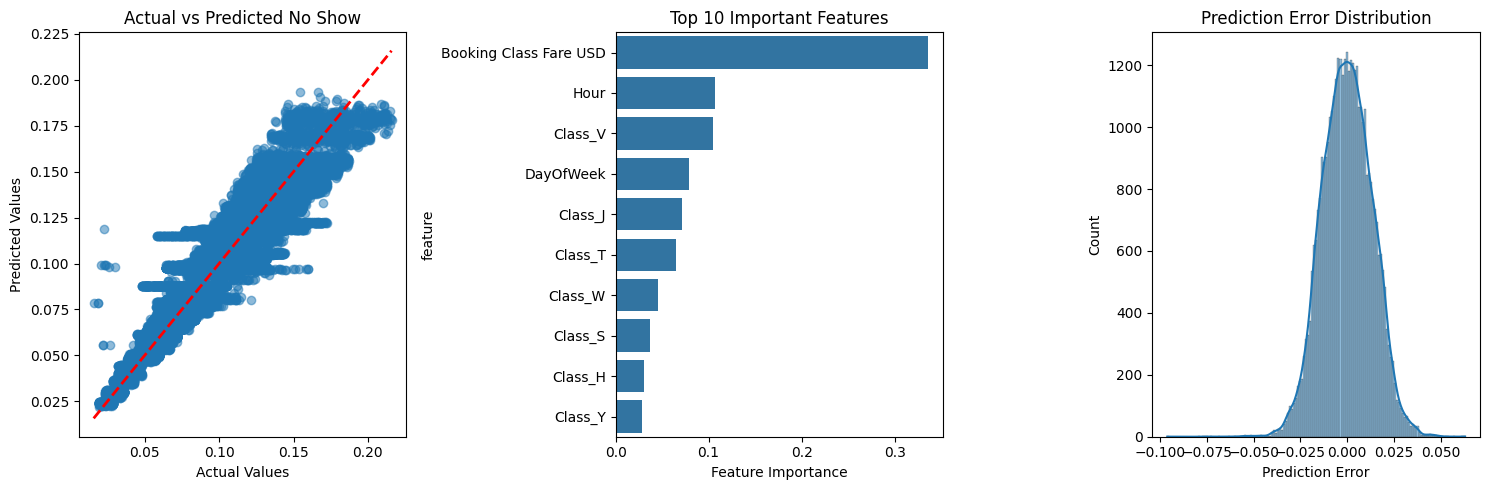


Starting cancellation prediction model training

Loading data...
Dataset shape: (195774, 14)

Preparing features for cancellation prediction...
Number of features: 32
Feature preparation completed successfully!

Training cancellation prediction model...
Model training completed!

Evaluating cancellation prediction model...
Mean Absolute Error: 0.0052
Root Mean Squared Error: 0.0063
R² Score: 0.8753


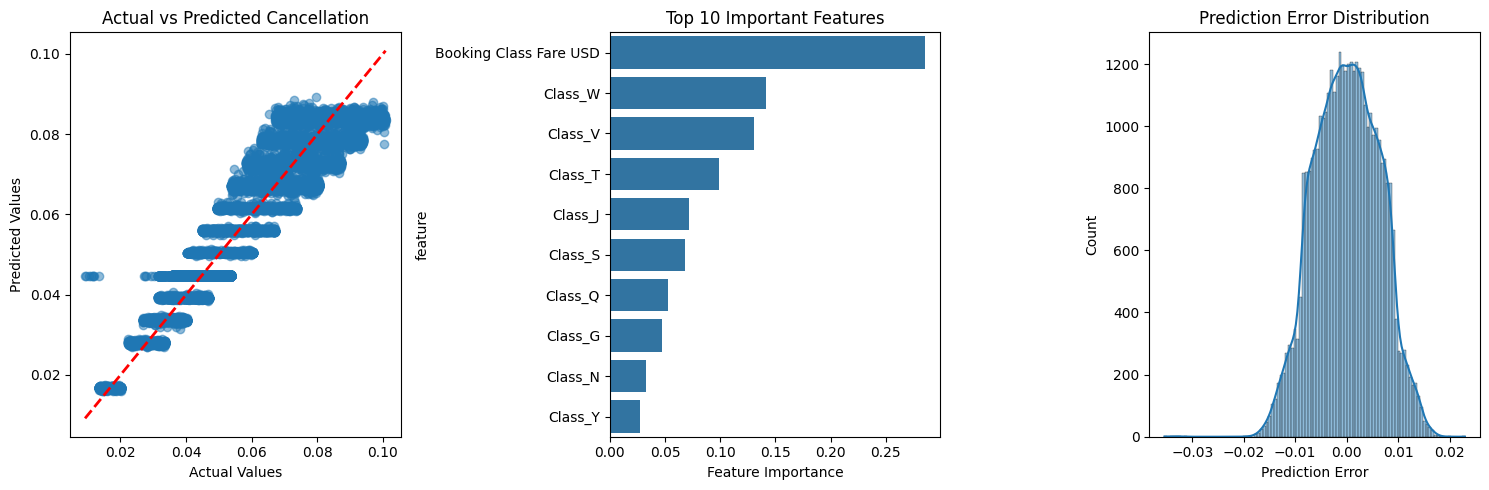


Starting overbooking prediction model training

Loading data...
Dataset shape: (195774, 14)

Preparing features for overbooking prediction...
Number of features: 32
Feature preparation completed successfully!

Training overbooking prediction model...
Model training completed!

Evaluating overbooking prediction model...
Mean Absolute Error: 0.0165
Root Mean Squared Error: 0.0218
R² Score: 0.8323


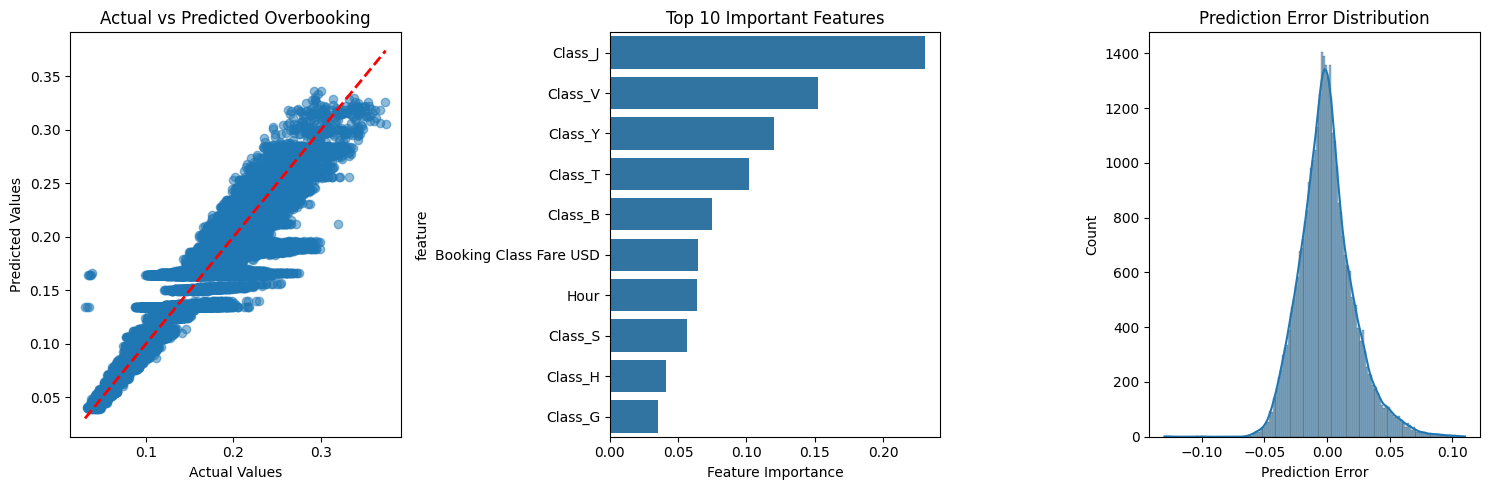


Starting denied_boarding prediction model training

Loading data...
Dataset shape: (195774, 14)

Preparing features for denied_boarding prediction...
Number of features: 32
Feature preparation completed successfully!

Training denied_boarding prediction model...
Model training completed!

Evaluating denied_boarding prediction model...
Mean Absolute Error: 0.0003
Root Mean Squared Error: 0.0004
R² Score: 0.8323


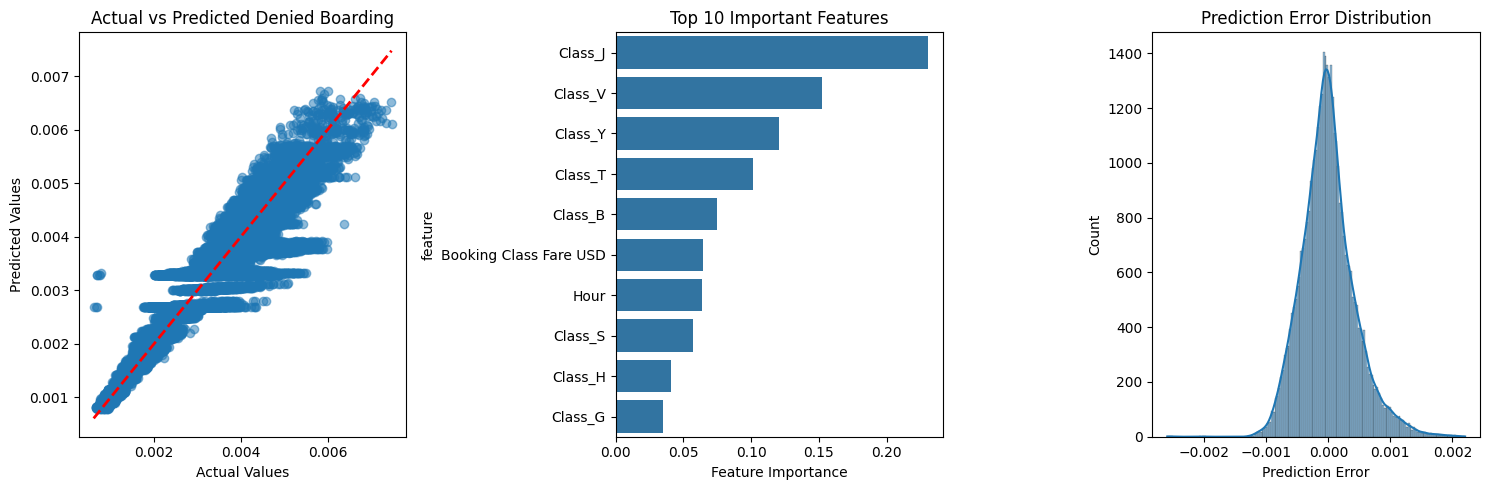


All models have been trained and evaluated!


In [8]:
def main():
    # File path
    data_path = '/content/drive/MyDrive/forecasting_data/forecasting_booking_12m.csv'  # Use 12-month booking data for better patterns

    # Train models for each type
    target_types = ['no_show', 'cancellation', 'overbooking', 'denied_boarding']
    models = {}

    for target_type in target_types:
        models[target_type] = train_specific_model(data_path, target_type)

        # Clear memory after each model
        gc.collect()
        plt.close('all')

    print("\nAll models have been trained and evaluated!")
    return models

if __name__ == "__main__":
    models = main()

In [9]:
def print_feature_importance(model):
    """
    Print feature importance for each target type after model training
    """
    for target_type, forecaster in model.items():
        print(f"\n{'='*50}")
        print(f"Feature Importance for {target_type.replace('_', ' ').title()} Model")
        print(f"{'='*50}")

        # Get top 15 features
        top_features = forecaster.feature_importance.head(15)

        # Print in a formatted way
        print("\nTop 15 Most Important Features:")
        print("-" * 60)
        print(f"{'Feature':<40} {'Importance':>10}")
        print("-" * 60)
        for _, row in top_features.iterrows():
            print(f"{row['feature']:<40} {row['importance']:>10.4f}")
        print("-" * 60)
        print("\n")

# Use this after model training
if models:  # Check if models dictionary is not empty
    print_feature_importance(models)


Feature Importance for No Show Model

Top 15 Most Important Features:
------------------------------------------------------------
Feature                                  Importance
------------------------------------------------------------
Booking Class Fare USD                       0.3354
Hour                                         0.1069
Class_V                                      0.1042
DayOfWeek                                    0.0785
Class_J                                      0.0719
Class_T                                      0.0645
Class_W                                      0.0455
Class_S                                      0.0366
Class_H                                      0.0300
Class_Y                                      0.0283
Cabin_Y                                      0.0227
Class_G                                      0.0219
Cabin_J                                      0.0189
Class_Q                                      0.0182
Class_B                    

All models are performing well with high R² scores (above 0.83). Each model's performance and feature importance:

No-Show Model:

* R² Score: 0.8401 (84% variance explained)
* MAE: 0.0107
* Key predictors:

* Booking Class Fare USD (33.54%)
* Hour of departure (10.69%)
* Class_V (10.42%)
* Day of week (7.85%)

Cancellation Model:

* R² Score: 0.8753 (highest performing model)
* MAE: 0.0052 (lowest error)
* Key predictors:

* Booking Class Fare USD (28.50%)
* Class_W (14.15%)
* Class_V (13.09%)
* Class_T (9.91%)

Overbooking Model:

* R² Score: 0.8323
* MAE: 0.0165
* Key predictors:

* Class_J (23.02%)
* Class_V (15.21%)
* Class_Y (12.04%)
* Class_T (10.16%)

Denied Boarding Model:

* R² Score: 0.8323
* MAE: 0.0003 (very low due to rare events)
* Feature importance mirrors overbooking model, which makes sense as they're closely related

Common patterns:

* Booking class and fare are consistently important across all models
* Time-related features (Hour, DayOfWeek) are more important for no-shows
* Cabin class has relatively lower importance compared to booking class

# **Advanced Feature Analysis and Selection**

In [10]:
from sklearn.feature_selection import SelectFromModel

In [21]:
def print_feature_importance_summary(models):
    """Print feature importance summary for all models"""
    for target_type, forecaster in models.items():
        print(f"\n{target_type.replace('_', ' ').title()} Model - Top 10 Features:")
        print("=" * 60)
        print(f"{'Feature':<40} {'Importance':>10}")
        print("-" * 60)

        # Get feature importance from the model
        importances = pd.DataFrame({
            'feature': forecaster.model.feature_names_in_,
            'importance': forecaster.model.feature_importances_
        }).sort_values('importance', ascending=False)

        # Print top 10 features
        for _, row in importances.head(10).iterrows():
            print(f"{row['feature']:<40} {row['importance']:>10.4f}")
        print("-" * 60)

In [25]:
def plot_feature_importance_comparison(models):
    """Create feature importance comparison visualization"""
    plt.figure(figsize=(15, 8))

    # Collect feature importance data
    all_importances = {}
    for target_type, forecaster in models.items():
        importances = pd.DataFrame({
            'feature': forecaster.model.feature_names_in_,
            'importance': forecaster.model.feature_importances_
        }).sort_values('importance', ascending=False)

        all_importances[target_type] = importances.set_index('feature')['importance']

    # Create comparison dataframe
    comparison_df = pd.DataFrame(all_importances)

    # Plot heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(comparison_df.head(10), annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title('Top 10 Features Importance Across Models')
    plt.xlabel('Models')
    plt.ylabel('Features')

    # Plot correlation between target variables
    df = pd.read_csv('/content/drive/MyDrive/forecasting_data/forecasting_booking_12m.csv')
    target_vars = ['no_show', 'cancellation', 'overbooking', 'denied_boarding']
    corr_matrix = df[target_vars].corr()

    plt.subplot(1, 2, 2)
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm')
    plt.title('Target Variable Correlation')

    plt.tight_layout()
    plt.show()


In [28]:
def plot_temporal_patterns(df):
    """Plot temporal patterns for all target variables with better formatting"""
    # Safely extract temporal features
    df = df.copy()

    # Safely extract hour from time string
    def extract_hour(time_str):
        try:
            if ':' in str(time_str):
                return int(str(time_str).split(':')[0])
            return int(str(time_str)[:2])
        except:
            return 12

    # Process temporal features
    df['Hour'] = df['Dep_time'].apply(extract_hour)
    df['DayOfWeek'] = pd.to_datetime(df['Dep_Date']).dt.dayofweek
    df['Month'] = pd.to_datetime(df['Dep_Date']).dt.month

    target_vars = ['no_show', 'cancellation', 'overbooking', 'denied_boarding']

    # Create temporal pattern plots with increased figure size and spacing
    plt.figure(figsize=(20, 6))

    # Hour patterns
    hourly_means = df.groupby('Hour')[target_vars].mean()
    print("\nHourly Patterns (Average Values):")
    print("=" * 60)
    print(hourly_means.round(4))

    plt.subplot(1, 3, 1)
    sns.heatmap(hourly_means.T, cmap='YlOrRd', annot=True, fmt='.3f',
                cbar_kws={'label': 'Average Rate'})
    plt.title('Patterns by Hour', pad=20)
    plt.xlabel('Hour of Day', labelpad=10)
    plt.ylabel('Event Type', labelpad=10)

    # Day of week patterns
    daily_means = df.groupby('DayOfWeek')[target_vars].mean()
    print("\nDaily Patterns (Average Values):")
    print("=" * 60)
    print(daily_means.round(4))

    plt.subplot(1, 3, 2)
    sns.heatmap(daily_means.T, cmap='YlOrRd', annot=True, fmt='.3f',
                cbar_kws={'label': 'Average Rate'})
    plt.title('Patterns by Day of Week', pad=20)
    plt.xlabel('Day of Week (0=Monday)', labelpad=10)
    plt.ylabel('Event Type', labelpad=10)

    # Monthly patterns
    monthly_means = df.groupby('Month')[target_vars].mean()
    print("\nMonthly Patterns (Average Values):")
    print("=" * 60)
    print(monthly_means.round(4))

    plt.subplot(1, 3, 3)
    sns.heatmap(monthly_means.T, cmap='YlOrRd', annot=True, fmt='.3f',
                cbar_kws={'label': 'Average Rate'})
    plt.title('Patterns by Month', pad=20)
    plt.xlabel('Month', labelpad=10)
    plt.ylabel('Event Type', labelpad=10)

    # Adjust layout to prevent overlap
    plt.tight_layout(w_pad=3.0)  # Increase spacing between subplots
    plt.show()

Loading data...
Dataset shape: (195774, 14)

Printing Feature Importance Summary...

No Show Model - Top 10 Features:
Feature                                  Importance
------------------------------------------------------------
Booking Class Fare USD                       0.3354
Hour                                         0.1069
Class_V                                      0.1042
DayOfWeek                                    0.0785
Class_J                                      0.0719
Class_T                                      0.0645
Class_W                                      0.0455
Class_S                                      0.0366
Class_H                                      0.0300
Class_Y                                      0.0283
------------------------------------------------------------

Cancellation Model - Top 10 Features:
Feature                                  Importance
------------------------------------------------------------
Booking Class Fare USD              

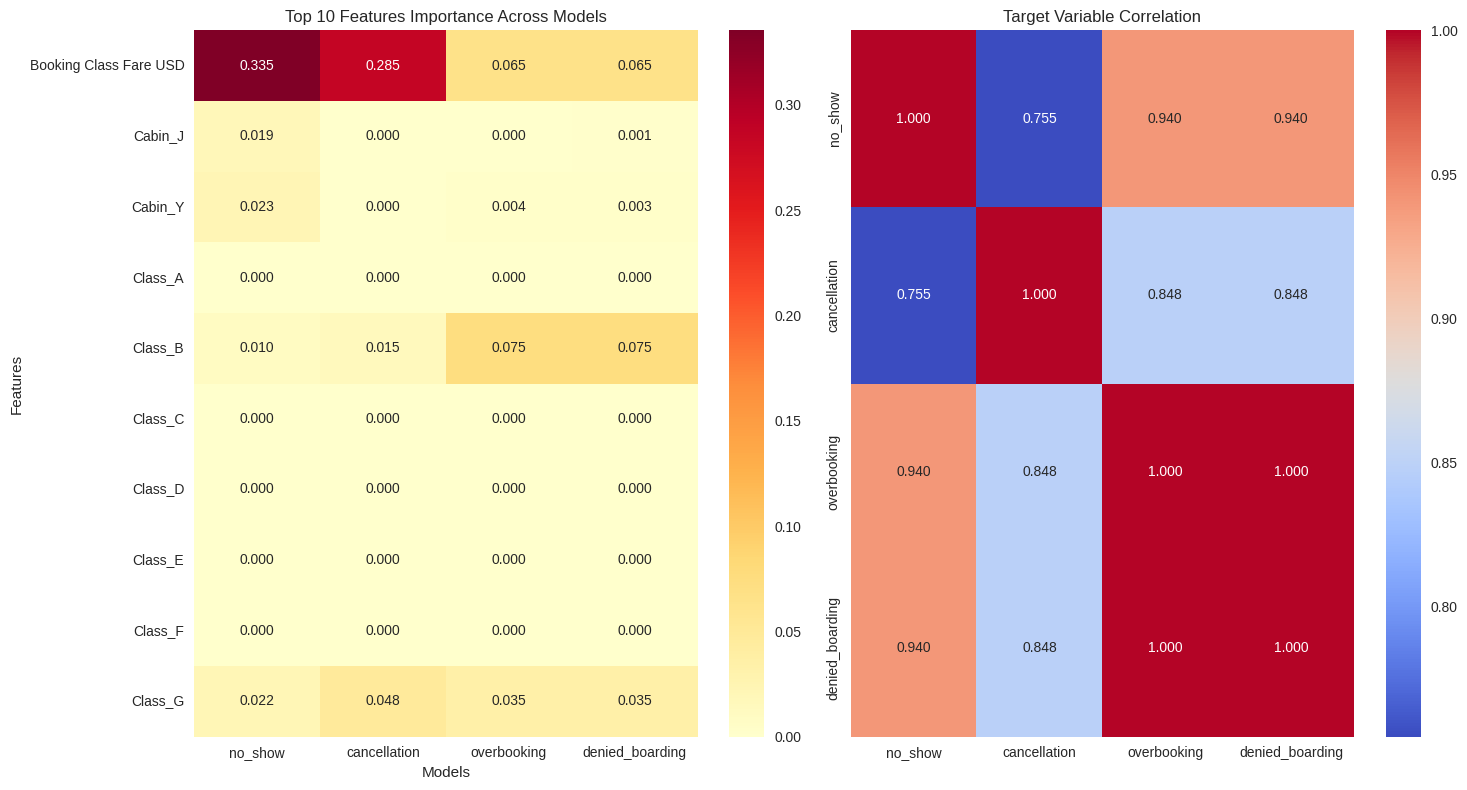


Analyzing Temporal Patterns...

Hourly Patterns (Average Values):
      no_show  cancellation  overbooking  denied_boarding
Hour                                                     
5      0.0818        0.0513       0.1381           0.0028
6      0.0833        0.0514       0.1429           0.0029
7      0.0824        0.0513       0.1328           0.0027
8      0.0840        0.0516       0.1364           0.0027
9      0.0825        0.0511       0.1335           0.0027
10     0.1036        0.0518       0.1667           0.0033
11     0.1052        0.0520       0.1682           0.0034
12     0.1043        0.0515       0.1621           0.0032
13     0.1045        0.0517       0.1750           0.0035
14     0.1045        0.0512       0.1548           0.0031
15     0.1039        0.0514       0.1791           0.0036
16     0.1041        0.0515       0.1560           0.0031
17     0.1034        0.0512       0.1626           0.0033
18     0.1038        0.0514       0.1574           0.0031
19   

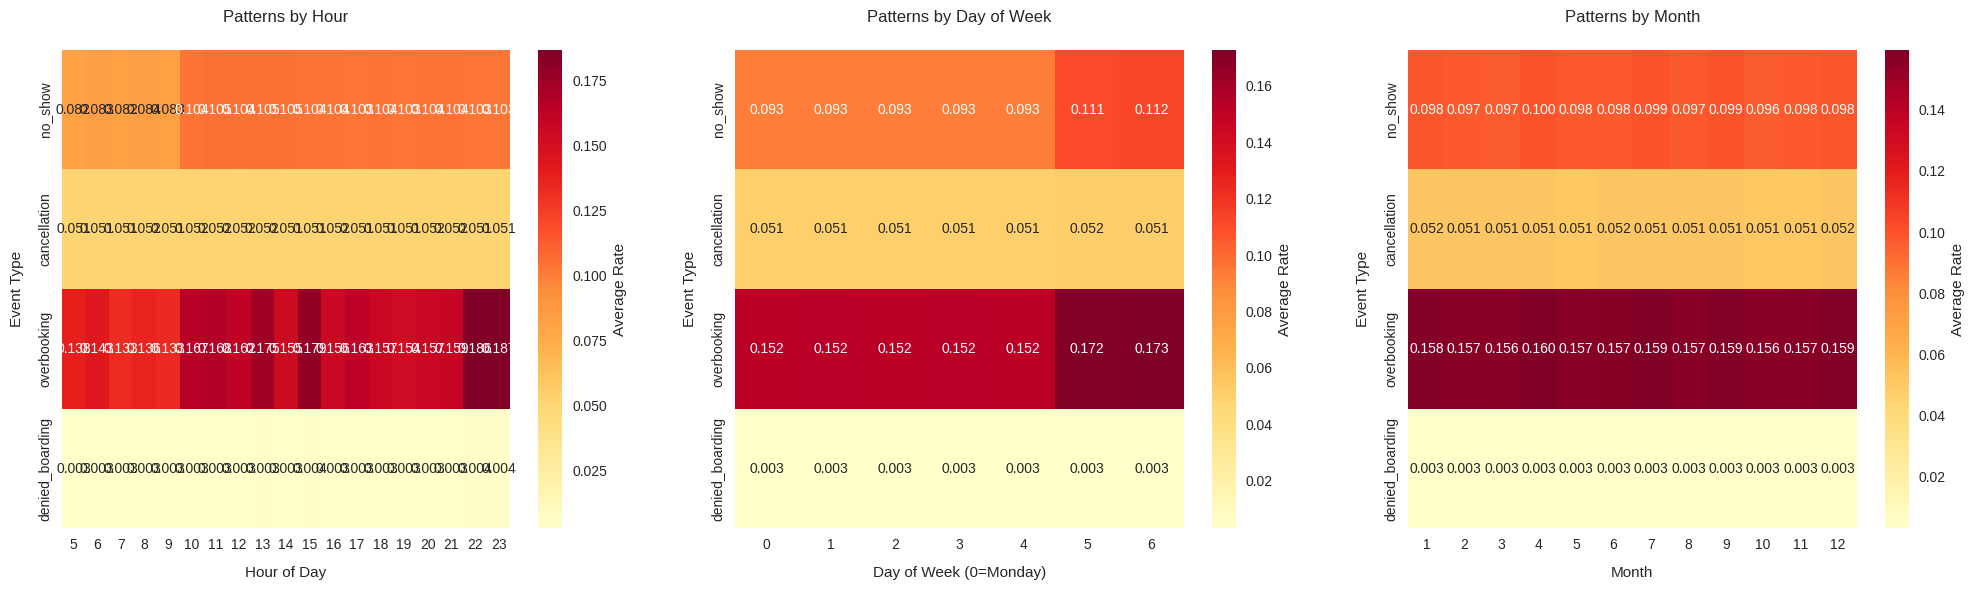

In [29]:
def main():
    # Load the processed data
    print("Loading data...")
    df = pd.read_csv('/content/drive/MyDrive/forecasting_data/forecasting_booking_12m.csv')

    print(f"Dataset shape: {df.shape}")

    if 'models' in globals():
        print("\nPrinting Feature Importance Summary...")
        print_feature_importance_summary(models)

        print("\nGenerating Feature Importance Comparison Plot...")
        plot_feature_importance_comparison(models)

        print("\nAnalyzing Temporal Patterns...")
        plot_temporal_patterns(df)
    else:
        print("Please run this after model training when 'models' variable is available.")

if __name__ == "__main__":
    main()

Feature Importance Summary:

No Show Model:

* Booking fare (33.54%) is the strongest predictor
* Hour of day (10.69%) and Class_V (10.42%) are next most important
* Time-related features have high importance

Cancellation Model:

* Booking fare (28.50%) remains most important
* Class_W (14.15%) and Class_V (13.09%) are strong predictors
* Less influenced by time-related features

Overbooking & Denied Boarding Models (identical patterns):

* Class_J (23.02%) is most important
* Class_V (15.21%) and Class_Y (12.04%) follow
* Fare is less important (6.48%) compared to other models

Temporal Patterns:

Hourly Patterns:

No-shows:

* Lower rates (8.18-8.40%) in early morning (5-9 AM)
* Higher rates (10.31-10.52%) during midday and evening
* Peak at 11 AM (10.52%)

Cancellations:

* Relatively stable throughout day (5.11-5.20%)
* Slight peak at 11 AM (5.20%)

Overbooking:

* Highest in late evening (22-23h: 18.65-18.70%)
* Lower in early morning (13.28-13.64%)
* Significant variation throughout day

Daily Patterns:

* Weekends (days 5-6) show higher rates for:

* No-shows (11.07-11.22% vs 9.28-9.32% weekdays)
* Overbooking (17.20-17.28% vs 15.20-15.24% weekdays)

* Cancellations remain stable across week (≈5.14-5.15%)

Monthly Patterns:

Generally stable across months:

* No-shows: 9.63-9.96%
* Cancellations: 5.11-5.15%
* Overbooking: 15.58-15.96%
* Slight peaks in April and July

Key Insights:

* Booking class and fare are the strongest predictors overall
* Time of day significantly affects no-shows and overbooking
* Weekends show notably higher rates of no-shows and overbooking
* Cancellations are more stable across all temporal dimensions
* Monthly variations are minimal, suggesting seasonal effects are limited

# **Recommendations Based on Analysis Patterns**

In [30]:
def generate_recommendations():
    """
    Generate structured recommendations based on analysis patterns
    """
    recommendations = {
        "pricing_and_booking": {
            "title": "Pricing and Booking Class Strategies",
            "insights": [
                "Booking fare is the strongest predictor for no-shows (33.54%) and cancellations (28.50%)",
                "Class_J and Class_V are consistently important across all models",
                "Economy classes show different risk patterns than premium classes"
            ],
            "recommendations": [
                "Implement dynamic pricing adjustments for high-risk time slots",
                "Consider stricter cancellation policies for discount fare classes",
                "Develop targeted overbooking strategies by booking class",
                "Offer incentives for early check-in in high-risk booking classes"
            ]
        },

        "time_based": {
            "title": "Time-Based Management Strategies",
            "insights": [
                "Higher no-show rates during midday (10.31-10.52%)",
                "Early morning flights (5-9 AM) have lower no-show rates (8.18-8.40%)",
                "Peak overbooking risk in late evening (18.65-18.70%)",
                "Weekend rates significantly higher than weekdays"
            ],
            "recommendations": [
                "Adjust overbooking limits by time of day:",
                "- Reduce morning flight overbooking (5-9 AM)",
                "- Increase midday flight overbooking (10 AM-3 PM)",
                "- Implement special monitoring for evening flights",
                "Develop weekend-specific strategies:",
                "- Higher overbooking allowances",
                "- Additional standby capacity",
                "- Enhanced customer communication"
            ]
        },

        "operational": {
            "title": "Operational Optimization Strategies",
            "insights": [
                "Cancellation rates remain stable (≈5.14-5.15%)",
                "Overbooking risks vary significantly by class and time",
                "Monthly variations are minimal"
            ],
            "recommendations": [
                "Resource allocation adjustments:",
                "- Increase staff during peak no-show periods",
                "- Optimize check-in counter operations by time slot",
                "- Adjust standby seat availability by flight time",
                "Implement proactive management:",
                "- Automated reminders for high-risk bookings",
                "- Early check-in incentives during peak periods",
                "- Real-time monitoring of check-in patterns"
            ]
        },

        "customer_service": {
            "title": "Customer Service Enhancements",
            "insights": [
                "Different booking classes show distinct behavior patterns",
                "Time of day significantly impacts customer behavior",
                "Weekend travel shows unique patterns"
            ],
            "recommendations": [
                "Develop targeted communication strategies:",
                "- Class-specific reminder systems",
                "- Time-based check-in reminders",
                "- Weekend-specific communications",
                "Enhance customer experience:",
                "- Priority handling for high-risk flights",
                "- Flexible rebooking options for specific classes",
                "- Automated support during peak periods"
            ]
        }
    }

    # Print recommendations in a structured format
    print("\nRECOMMENDATIONS BASED ON PATTERN ANALYSIS")
    print("="*50)

    for category, content in recommendations.items():
        print(f"\n{content['title'].upper()}")
        print("-"*50)

        print("\nKey Insights:")
        for insight in content['insights']:
            print(f"• {insight}")

        print("\nRecommendations:")
        for rec in content['recommendations']:
            print(f"• {rec}")

        print("="*50)

    return recommendations

# Generate and print recommendations
recommendations = generate_recommendations()


RECOMMENDATIONS BASED ON PATTERN ANALYSIS

PRICING AND BOOKING CLASS STRATEGIES
--------------------------------------------------

Key Insights:
• Booking fare is the strongest predictor for no-shows (33.54%) and cancellations (28.50%)
• Class_J and Class_V are consistently important across all models
• Economy classes show different risk patterns than premium classes

Recommendations:
• Implement dynamic pricing adjustments for high-risk time slots
• Consider stricter cancellation policies for discount fare classes
• Develop targeted overbooking strategies by booking class
• Offer incentives for early check-in in high-risk booking classes

TIME-BASED MANAGEMENT STRATEGIES
--------------------------------------------------

Key Insights:
• Higher no-show rates during midday (10.31-10.52%)
• Early morning flights (5-9 AM) have lower no-show rates (8.18-8.40%)
• Peak overbooking risk in late evening (18.65-18.70%)
• Weekend rates significantly higher than weekdays

Recommendations:
• A